In [1]:
from sphynx import sphynx, NODE_SMALL, NODE_MEDIUM, NODE_LARGE
spark = sphynx.get_spark(executor_count=20, app_name='apps', node_spec=NODE_MEDIUM)

Spark cluster not assigned. creating a new one...
Node spec: 20 executors with 24G RAM each
Job Port 4049 is assigned for requested cluster
Waiting for Spark master to be available...
Spark master launched!
Creating new Spark session, name: apps...
Waiting for all executors ready...
15/20 executors ready
16/20 executors ready
17/20 executors ready
19/20 executors ready
All executors connected!
Complete! elapsed time: 00:00:54


In [2]:
import os
os.system('pip install seaborn')
os.system('pip install sklearn')

from pubg_util import load_schema
import datetime
#from frame import data_processing_module
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.linalg import SparseVector, DenseVector
import os, sys

In [3]:
# 9 variables
variables = [
    'consecutive_not_login_day',
    'FQ14',
    'Level',
    'classic_count_daily',
    'avg_score',
    'Escape_Ratio',
    'Top10_ratio',
    'walking_ratio',
    'all_used_map_count'
]

#alias = ['var'+str(i) for i in range(len(variables))]
#print(alias)

In [4]:
data = spark.read.parquet("s3a://pubg-log-labs/mobile-analytics/profiling/churn_model_test_val/{}".format('2020-04-*'))
data = data.select(data.columns).filter("std_dt between date('2020-04-01') and date_add('2020-04-01', 7)")
dataset = data.sample(False, 0.2, 100)
print(dataset.count(), len(dataset.columns))
#if not data.is_cached: data.cache()

7582745 17


In [5]:
#print(dataset.describe().show())
if not dataset.is_cached: dataset.cache() 

# Preprocessing(scaling)

In [6]:
# preprocessing

print('[Original]')
print(dataset.select(variables).where("vopenid = '1000509947643177'").show(truncate=False))

assembler = VectorAssembler(inputCols=variables,outputCol="features")
v_Data = assembler.setHandleInvalid("skip").transform(dataset) ###temp(4/1)
print('[Vector]')
print(v_Data.select('features').where("vopenid = '1000509947643177'").show(truncate=False))

minmax_scaler = MinMaxScaler(inputCol="features", outputCol="m_features")
minmax_scalerModel = minmax_scaler.fit(v_Data)
m_Data = minmax_scalerModel.transform(v_Data)
print('[Minmax]')
print(m_Data.select('m_features').where("vopenid = '1000509947643177'").show(truncate=False))

normal_scaler = StandardScaler(inputCol='m_features', outputCol="n_features", withStd=True, withMean=False)
normal_scalerModel = normal_scaler.fit(m_Data)
n_Data = normal_scalerModel.transform(m_Data)
print('[Normal]')
print(n_Data.select('n_features').where("vopenid = '1000509947643177'").show(truncate=False))
print(n_Data.count())

[Original]
+-------------------------+----+-----+-------------------+---------+------------+-----------+-------------+------------------+
|consecutive_not_login_day|FQ14|Level|classic_count_daily|avg_score|Escape_Ratio|Top10_ratio|walking_ratio|all_used_map_count|
+-------------------------+----+-----+-------------------+---------+------------+-----------+-------------+------------------+
+-------------------------+----+-----+-------------------+---------+------------+-----------+-------------+------------------+

None
[Vector]
+--------+
|features|
+--------+
+--------+

None
[Minmax]
+----------+
|m_features|
+----------+
+----------+

None
[Normal]
+----------+
|n_features|
+----------+
+----------+

None
7582745


In [7]:
# scaled data
scaled_data = n_Data.select("vopenid","n_features").withColumnRenamed("n_features","features")
if not scaled_data.is_cached: scaled_data.cache()
scaled_data.where("vopenid = '1000509947643177'").show(truncate=False)

+-------+--------+
|vopenid|features|
+-------+--------+
+-------+--------+



# PCA(reducing dimension)

In [8]:
pca = PCA(k=2, inputCol="features", outputCol="p_features")
model = pca.fit(scaled_data.select('features'))
pcaData = model.transform(scaled_data)

In [ ]:
pcaData.where("vopenid = '1000509947643177'").show(truncate=False)

In [9]:
pcaData = pcaData.select('vopenid', 'p_features').withColumnRenamed("p_features","features")

# k-means clustering

### k selection with silhouette avg score

In [65]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
range_n_clusters = list(range(2,5))
X = pcaData.select('features').cache()
scores = list()
errors = list()
res = dict()

for k_value in range_n_clusters:
    kmeans = KMeans(k=k_value, seed=1)  # k clusters here(n>k, n=9)
    model = kmeans.fit(X)
    # Make predictions
    predictions = model.transform(X)
    # Evaluate clustering by computing Silhouette score
    silhouette = evaluator.evaluate(predictions)
    e = model.computeCost(predictions)
    scores.append(silhouette)
    errors.append(e)
    centers = np.array([list(c) for c in model.clusterCenters()])
    print("For n_clusters =", k_value, ", Silhouette with squared euclidean distance =", silhouette, ", Errors in clusters =", e) #10'
    
    res[k_value] = [silhouette, e, centers, predictions]

For n_clusters = 2 , Silhouette with squared euclidean distance = 0.7709076291890298 , Errors in clusters = 15433172.027752953
For n_clusters = 3 , Silhouette with squared euclidean distance = 0.7275918589659964 , Errors in clusters = 8712681.513028618
For n_clusters = 4 , Silhouette with squared euclidean distance = 0.6512408137090744 , Errors in clusters = 7153124.510472448


In [66]:
res

{2: [0.7709076291890298, 15433172.027752953, array([[ 4.45125   , -0.8136252 ],
         [ 0.49701311, -0.21315224]]), DataFrame[features: vector, prediction: int]],
 3: [0.7275918589659964, 8712681.513028618, array([[ 0.44072078, -0.12364882],
         [ 3.45338297, -2.17303309],
         [ 4.89732152, -0.1328625 ]]), DataFrame[features: vector, prediction: int]],
 4: [0.6512408137090744, 7153124.510472448, array([[-0.00644096, -0.7271691 ],
         [ 4.9026079 , -0.13263551],
         [ 3.47374831, -2.18327465],
         [ 0.94009744,  0.4813982 ]]), DataFrame[features: vector, prediction: int]]}

In [13]:
k=2
res[k][-1]

DataFrame[features: vector, prediction: int]

In [14]:
fname = 'download/prediction_' + str(3) + '.csv'
temp_df = res[3][-1]
if not os.path.isfile(fname):
    temp_df.groupBy('prediction').count().orderBy('prediction').toPandas().to_csv(fname)

In [15]:
fname = 'download/prediction_' + str(4) + '.csv'
temp_df = res[4][-1]
if not os.path.isfile(fname):
    temp_df.groupBy('prediction').count().orderBy('prediction').toPandas().to_csv(fname)

k=2
center = res[k][-2].tolist()
df0 = res[k][-1].toPandas()


In [29]:
elements = np.array([np.array(row) for row in df0['features'].tolist()])

df0['pca_x'] = elements[:,0]
df0['pca_y'] = elements[:,1]

In [ ]:
#label = list(range(k))
df0['dist'] = df0[df0.prediction == 1].apply(lambda r: math.sqrt((center[0] - r.pca_x)**2 + (center[1] - r.pca_y)**2), axis=1)
res = df0.loc[df0['dist'].idxmin(axis = 0)]
res

In [20]:
list1= [2,3,4]
list2= [res[2][-2].tolist(), res[3][-2].tolist(), res[4][-2].tolist()]
center_df = pd.DataFrame(list(zip(list1, list2 )), columns=['k', 'centers'])
center_df

,k,centers
0,2,"[[4.451250003687412, -0.8136251955881836], [0...."
1,3,"[[0.4407207796445771, -0.12364881901265964], [..."
2,4,"[[-0.006440964587440056, -0.7271691000146911],..."


In [ ]:
fname = 'download/prediction_' + str(k) + '.csv'
df.groupBy('prediction').count().orderBy('prediction').toPandas().to_csv(fname)

In [ ]:
elements = np.array([np.array(row) for row in df['features'].tolist()])

df['pca_x'] = elements[:,0]
df['pca_y'] = elements[:,1]

sns.set()
x, y = elements.T
plt.scatter(x,y)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
fig = plt.gcf()
fig.set_size_inches(15, 12)
fname1 = 'download/before_' + str(k) + '.png'
if not os.path.isfile(fname1): plt.savefig(fname1)

In [ ]:
markers=['o', 's', '^', 'x', 'v']
for label in list(range(k)):
    label_cluster = df[df['prediction']==label]
    center_x_y = centers[label]
    plt.scatter(x=label_cluster['pca_x'], y=label_cluster['pca_y'], marker=markers[label] )
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$' % label)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
fig = plt.gcf()
fig.set_size_inches(15, 12)
fname2 = 'download/after_' + str(k) + '.png'
if not os.path.isfile(fname2): plt.savefig(fname2)

In [15]:
scores = np.round(scores, decimals = 6) 
errors = np.round(errors, decimals = 6) 
silhouettes = pd.DataFrame(list(zip(range_n_clusters, scores, errors)), columns =['num_clusters', 'silhouette', 'sum_errors']) 
#silhouettes
silhouettes.to_csv('silhouette.csv')

### clustering

In [42]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import os.path

%matplotlib inline
X = pcaData.select('features').cache()

def clustering(k):
    k_value = k
    kmeans = KMeans(k=k_value, seed=1)  # k clusters here(n>k, n=9)
    model = kmeans.fit(X)
    transformed = model.transform(X)
    if not transformed.is_cached: transformed.cache()
    # prediction with value counts
    fname = 'download/prediction_' + str(k) + '.csv'
    if not os.path.isfile(fname):
        transformed.groupBy('prediction').count().orderBy('prediction').toPandas().to_csv(fname)
    centers = np.array([list(c) for c in model.clusterCenters()])
    print('[DONE] clustering',k)
    return transformed, centers

def viz(df, centers, k):
    
    elements = np.array([np.array(row) for row in df['features'].tolist()])
    df['pca_x'] = elements[:,0]
    df['pca_y'] = elements[:,1]
    
    sns.set()
    x, y = elements.T
    plt.scatter(x,y)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    fig = plt.gcf()
    fig.set_size_inches(15, 12)
    fname1 = 'download/before_' + str(k) + '.png'
    if not os.path.isfile(fname1): plt.savefig(fname1)
    
    markers=['o', 's', '^', 'x', 'v']
    for label in list(range(k)):
        label_cluster = df[df['prediction']==label]
        center_x_y = centers[label]
        plt.scatter(x=label_cluster['pca_x'], y=label_cluster['pca_y'], marker=markers[label] )
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$' % label)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    fig = plt.gcf()
    fig.set_size_inches(15, 12)
    fname2 = 'download/after_' + str(k) + '.png'
    if not os.path.isfile(fname2): plt.savefig(fname2)
    print('[DONE] visualizing',k)
    return clusterDF

In [43]:
dic = dict()

for k_value in range_n_clusters[:3]:
    py_df, centers = clustering(k_value)
    pd_df = py_df.toPandas()
    viz(pd_df, centers, k_value)
    dic[k] = clusterDF #10.15~

KeyboardInterrupt: 

In [ ]:
def get_center(df, label):
    center = centers[label]
    clusterDF = df
    clusterDF['dist'] = clusterDF[clusterDF.prediction == label].apply(lambda r: math.sqrt((center[0] - r[-2])**2 + (center[1] - r[-1])**2), axis=1)
    res = clusterDF.loc[clusterDF['dist'].idxmin(axis = 0)]
    print(res)
    #print('[Center]', center)
    #print(res['vopenid'])

label = 0
get_center(dic[0], label)



In [ ]:

center = centers[label]
clusterDF['dist'] = clusterDF[clusterDF.prediction == label].apply(lambda r: math.sqrt((center[0] - r.pca_x)**2 + (center[1] - r.pca_y)**2), axis=1)
res = clusterDF.loc[clusterDF['dist'].idxmin(axis = 0)]
print(res)


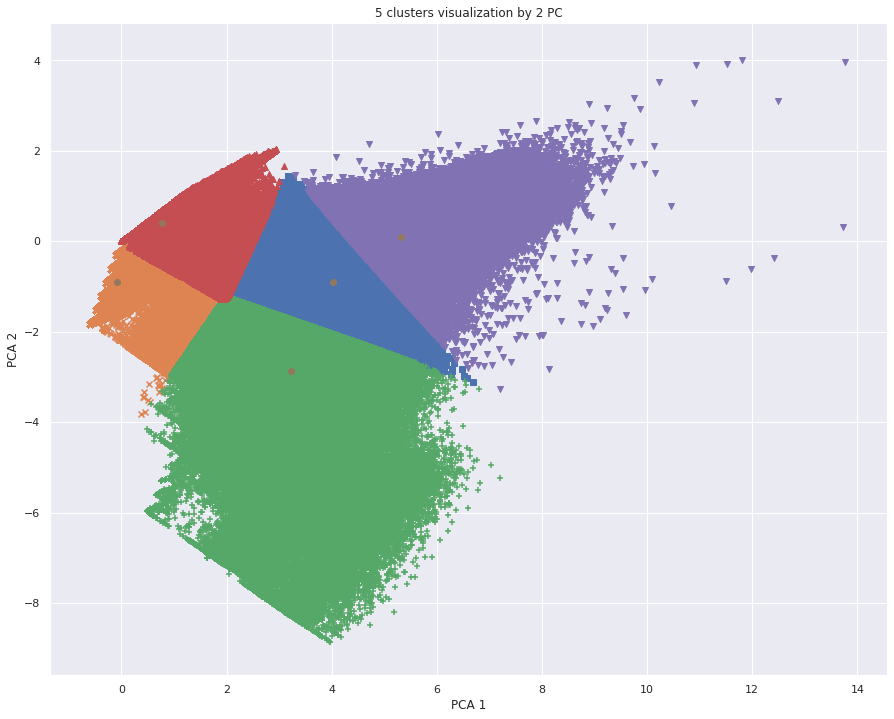

In [20]:
sns.set()

#markers=['o', 's', '^', 'x', '*']

marker0_ind = pd_df[pd_df['prediction']==0].index
marker1_ind = pd_df[pd_df['prediction']==1].index
marker2_ind = pd_df[pd_df['prediction']==2].index
marker3_ind = pd_df[pd_df['prediction']==3].index
marker4_ind = pd_df[pd_df['prediction']==4].index

plt.scatter(x=pd_df.loc[marker0_ind, 'pca_x'], y=pd_df.loc[marker0_ind, 'pca_y'], marker=',')
plt.scatter(x=pd_df.loc[marker1_ind, 'pca_x'], y=pd_df.loc[marker1_ind, 'pca_y'], marker='x')
plt.scatter(x=pd_df.loc[marker2_ind, 'pca_x'], y=pd_df.loc[marker2_ind, 'pca_y'], marker='+')
plt.scatter(x=pd_df.loc[marker3_ind, 'pca_x'], y=pd_df.loc[marker3_ind, 'pca_y'], marker='^')
plt.scatter(x=pd_df.loc[marker4_ind, 'pca_x'], y=pd_df.loc[marker4_ind, 'pca_y'], marker='v')

centers = np.array([list(c) for c in model.clusterCenters()])
plt.scatter(x=centers[:,0], y=centers[:,1], marker='o')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('5 clusters visualization by 2 PC')
fig = plt.gcf()
fig.set_size_inches(15, 12)
#fig.savefig('test2png.png', dpi=100)
plt.show()

In [21]:
transformed.groupBy('prediction').count().orderBy('prediction').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         0|1246548|
|         1| 720908|
|         2| 587126|
|         3| 950453|
|         4|1230714|
+----------+-------+



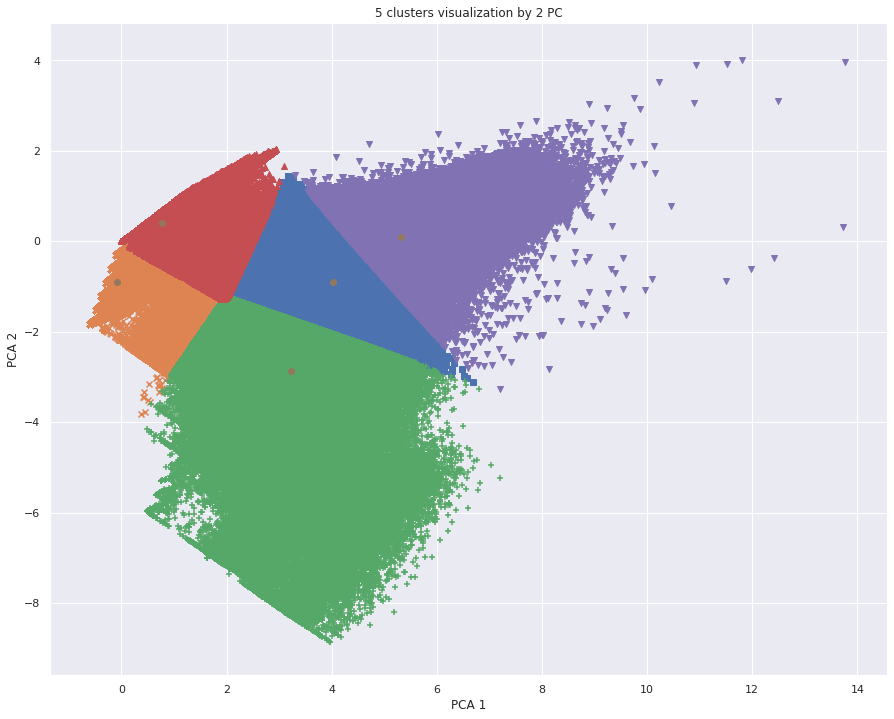

In [22]:
sns.set()

#markers=['o', 's', '^', 'x', '*']


marker0_ind = pd_df[pd_df['prediction']==0].index
marker1_ind = pd_df[pd_df['prediction']==1].index
marker2_ind = pd_df[pd_df['prediction']==2].index
marker3_ind = pd_df[pd_df['prediction']==3].index
marker4_ind = pd_df[pd_df['prediction']==4].index

plt.scatter(x=pd_df.loc[marker0_ind, 'pca_x'], y=pd_df.loc[marker0_ind, 'pca_y'], marker=',')
plt.scatter(x=pd_df.loc[marker1_ind, 'pca_x'], y=pd_df.loc[marker1_ind, 'pca_y'], marker='x')
plt.scatter(x=pd_df.loc[marker2_ind, 'pca_x'], y=pd_df.loc[marker2_ind, 'pca_y'], marker='+')
plt.scatter(x=pd_df.loc[marker3_ind, 'pca_x'], y=pd_df.loc[marker3_ind, 'pca_y'], marker='^')
plt.scatter(x=pd_df.loc[marker4_ind, 'pca_x'], y=pd_df.loc[marker4_ind, 'pca_y'], marker='v')

centers = np.array([list(c) for c in model.clusterCenters()])
plt.scatter(x=centers[:,0], y=centers[:,1], marker='o')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('5 clusters visualization by 2 PC')
fig = plt.gcf()
fig.set_size_inches(15, 12)
#fig.savefig('test2png.png', dpi=100)
plt.show()

In [32]:
res

{2: [0.7709076291890308, 15433172.027752949, array([[ 4.45125   , -0.8136252 ],
         [ 0.49701311, -0.21315224]]), DataFrame[features: vector, prediction: int]],
 3: [0.7275918589659955, 8712681.513028584, array([[ 0.44072078, -0.12364882],
         [ 3.45338297, -2.17303309],
         [ 4.89732152, -0.1328625 ]]), DataFrame[features: vector, prediction: int]],
 4: [0.6512408137090725, 7153124.510472449, array([[-0.00644096, -0.7271691 ],
         [ 4.9026079 , -0.13263551],
         [ 3.47374831, -2.18327465],
         [ 0.94009744,  0.4813982 ]]), DataFrame[features: vector, prediction: int]]}

In [33]:
k=2
df = res[k][-1].toPandas()
df.head(10)

,features,prediction
0,"[0.8550469087382171, 0.07952305186429703]",1
1,"[4.629402908015166, 0.010141498419566575]",0
2,"[3.321245022952846, -1.200156338347652]",0
3,"[3.7827611929930605, -2.046184789026323]",0
4,"[0.026402451355176715, -0.9101179974725746]",1
5,"[3.086785521890912, -0.25217424238395647]",0
6,"[-0.10642914308131861, -0.5696055887799354]",1
7,"[4.063599909732356, -2.580022902820085]",0
8,"[4.509755788533159, -0.5038933092921702]",0
9,"[2.348440594233659, -2.392641070607129]",0


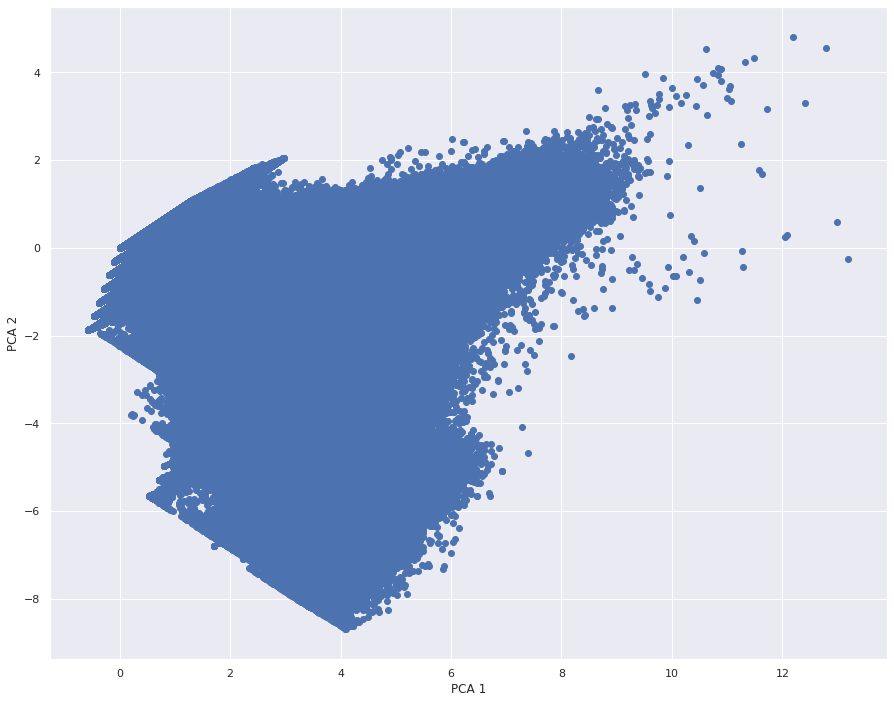

In [34]:
elements = np.array([np.array(row) for row in df['features'].tolist()])

df['pca_x'] = elements[:,0]
df['pca_y'] = elements[:,1]

sns.set()
x, y = elements.T
plt.scatter(x,y)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
fig = plt.gcf()
fig.set_size_inches(15, 12)
plt.show()

In [38]:
centers = res[k][-2].tolist()
centers

[[4.451250003687412, -0.8136251955881836],
 [0.4970131062638784, -0.21315224100265595]]

In [40]:
centers = res[k][-2].tolist()
unique_labels = list(range(k))

[0, 1]

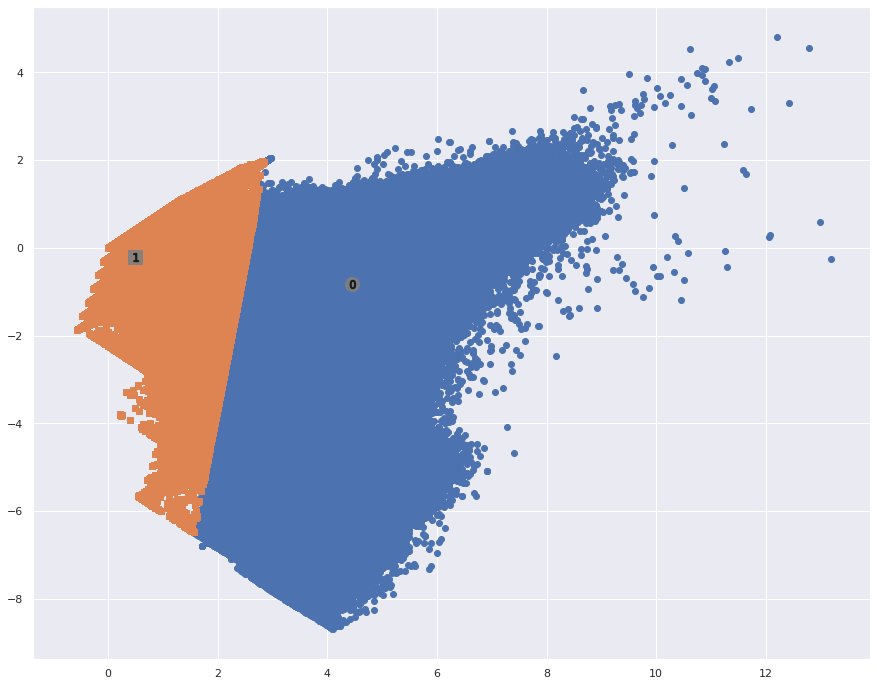

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

centers = res[k][-2].tolist()
unique_labels = list(range(k))

sns.set()
pd_df = df
markers=['o', 's', '^', 'x', 'v']
unique_labels = list(range(k))
for label in unique_labels:
    #rows
    label_cluster = pd_df[pd_df['prediction']==label]
    #center
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['pca_x'], y=label_cluster['pca_y'], marker=markers[label] )
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$' % label)

fig = plt.gcf()
fig.set_size_inches(15, 12)
    
plt.show()

In [43]:
k=3
df = res[k][-1].toPandas()

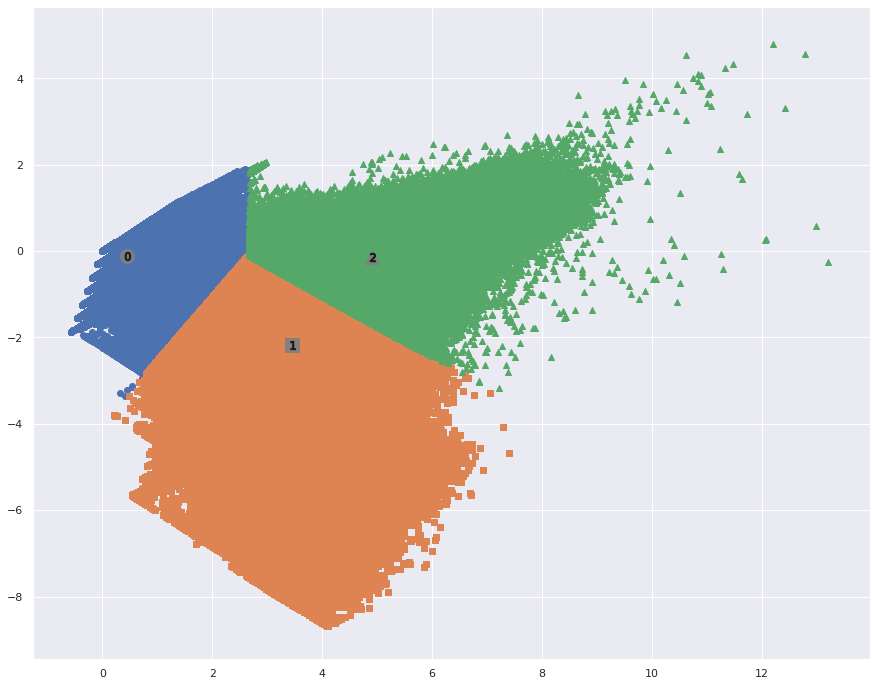

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

centers = res[k][-2].tolist()
unique_labels = list(range(k))
elements = np.array([np.array(row) for row in df['features'].tolist()])

df['pca_x'] = elements[:,0]
df['pca_y'] = elements[:,1]

sns.set()
pd_df = df
markers=['o', 's', '^', 'x', 'v']
unique_labels = list(range(k))
for label in unique_labels:
    #rows
    label_cluster = pd_df[pd_df['prediction']==label]
    #center
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['pca_x'], y=label_cluster['pca_y'], marker=markers[label] )
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$' % label)

fig = plt.gcf()
fig.set_size_inches(15, 12)
    
plt.show()

In [46]:
k=4
df_k4 = res[k][-1].toPandas()

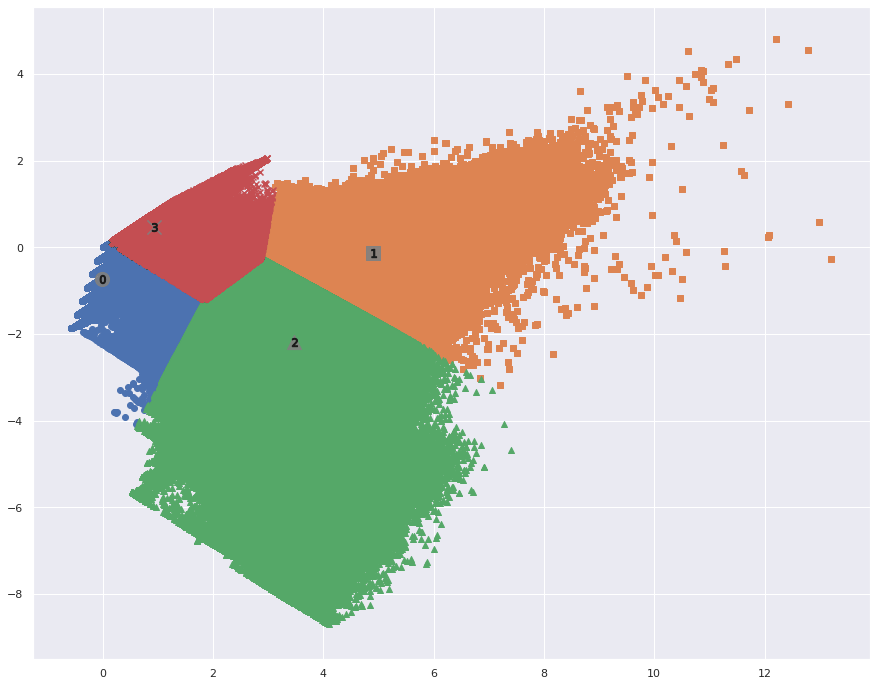

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

centers = res[k][-2].tolist()
unique_labels = list(range(k))
elements = np.array([np.array(row) for row in df_k4['features'].tolist()])

df_k4['pca_x'] = elements[:,0]
df_k4['pca_y'] = elements[:,1]

sns.set()
pd_df = df_k4
markers=['o', 's', '^', 'x', 'v']
unique_labels = list(range(k))
for label in unique_labels:
    #rows
    label_cluster = pd_df[pd_df['prediction']==label]
    #center
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['pca_x'], y=label_cluster['pca_y'], marker=markers[label] )
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$' % label)

fig = plt.gcf()
fig.set_size_inches(15, 12)
    
plt.show()

In [28]:
#error
def get_center(label):
    center = centers[label]
    clusterDF['dist'] = clusterDF[clusterDF.prediction == label].apply(lambda r: math.sqrt((center[0] - r[-2])**2 + (center[1] - r[-1])**2), axis=1)
    res = clusterDF.loc[clusterDF['dist'].idxmin(axis = 0)]
    print(res)
    #print('[Center]', center)
    #print(res['vopenid'])

In [29]:
#error
def get_center(label):
    center = centers[label]
    clusterDF['dist'] = clusterDF[clusterDF.prediction == label].apply(lambda r: math.sqrt((center[0] - r[-2])**2 + (center[1] - r[-1])**2), axis=1)
    res = clusterDF.loc[clusterDF['dist'].idxmin(axis = 0)]
    print(res)
    #print('[Center]', center)
    #print(res['vopenid'])

label = 0
center = centers[label]
clusterDF['dist'] = clusterDF[clusterDF.prediction == label].apply(lambda r: math.sqrt((center[0] - r.pca_x)**2 + (center[1] - r.pca_y)**2), axis=1)
res = clusterDF.loc[clusterDF['dist'].idxmin(axis = 0)]
print(res)
#get_center(label)

vopenid                               161724645115177
features      [4.025843707301121, -0.896259481192615]
prediction                                          0
pca_x                                         4.02584
pca_y                                       -0.896259
dist                                      0.000355917
Name: 1746838, dtype: object


In [69]:
df_k2 = res[2][-1].toPandas()
df_k3 = res[3][-1].toPandas()
df_k3 = res[4][-1].toPandas()

In [70]:
k=2
dataframe = df_k2
centers = res[k][-2].tolist()
elements = np.array([np.array(row) for row in dataframe['features'].tolist()])
dataframe['pca_x'] = elements[:,0]
dataframe['pca_y'] = elements[:,1]

print(centers)
for label in range(k):
    center = centers[label]
    dataframe['dist'] = dataframe[dataframe.prediction == label].apply(lambda r: math.sqrt((center[0] - r.pca_x)**2 + (center[1] - r.pca_y)**2), axis=1)
    #res = dataframe.loc[dataframe['dist'].idxmin(axis = 0)]
    print(k,',',label,',',dataframe['dist'].idxmin(axis = 0))

[[4.451250003687411, -0.8136251955881836], [0.4970131062638789, -0.213152241002656]]
2  -  6402931
2  -  366273


In [71]:
k=3
dataframe = df_k3
centers = res[k][-2].tolist()
elements = np.array([np.array(row) for row in dataframe['features'].tolist()])
dataframe['pca_x'] = elements[:,0]
dataframe['pca_y'] = elements[:,1]

print(centers)
for label in range(k):
    center = centers[label]
    dataframe['dist'] = dataframe[dataframe.prediction == label].apply(lambda r: math.sqrt((center[0] - r.pca_x)**2 + (center[1] - r.pca_y)**2), axis=1)
    #dataframe.loc[dataframe['dist'].idxmin(axis = 0)]
    print(k,',',label,',',dataframe['dist'].idxmin(axis = 0))

[[0.4407207796445771, -0.12364881901265964], [3.453382966324161, -2.173033093046808], [4.89732151721045, -0.13286249947533074]]
3  -  158
3  -  3374897
3  -  5765785


In [72]:
k=4
dataframe = df_k4
centers = res[k][-2].tolist()
elements = np.array([np.array(row) for row in dataframe['features'].tolist()])
dataframe['pca_x'] = elements[:,0]
dataframe['pca_y'] = elements[:,1]

print(centers)
for label in range(k):
    center = centers[label]
    dataframe['dist'] = dataframe[dataframe.prediction == label].apply(lambda r: math.sqrt((center[0] - r.pca_x)**2 + (center[1] - r.pca_y)**2), axis=1)
    print(k,',',label,',',dataframe['dist'].idxmin(axis = 0))

[[-0.006440964587440057, -0.727169100014691], [4.902607900779081, -0.13263551213049168], [3.4737483133192315, -2.183274645945686], [0.940097436473101, 0.4813982046178156]]
4  -  3453
4  -  7489332
4  -  2219894
4  -  260030


In [73]:
res

{2: [0.7709076291890298, 15433172.027752953, array([[ 4.45125   , -0.8136252 ],
         [ 0.49701311, -0.21315224]]), DataFrame[features: vector, prediction: int]],
 3: [0.7275918589659964, 8712681.513028618, array([[ 0.44072078, -0.12364882],
         [ 3.45338297, -2.17303309],
         [ 4.89732152, -0.1328625 ]]), DataFrame[features: vector, prediction: int]],
 4: [0.6512408137090744, 7153124.510472448, array([[-0.00644096, -0.7271691 ],
         [ 4.9026079 , -0.13263551],
         [ 3.47374831, -2.18327465],
         [ 0.94009744,  0.4813982 ]]), DataFrame[features: vector, prediction: int]]}

In [80]:
ori_df = dataset.toPandas()

In [91]:
result = pd.concat([ori_df.iloc[[6402931]], ori_df.iloc[[366273]]])
result.to_csv('centroids_2.csv')

In [92]:
result = pd.concat([ori_df.iloc[[158]], ori_df.iloc[[3374897]], ori_df.iloc[[5765785]]])
result.to_csv('centroids_3.csv')

In [93]:
result = pd.concat([ori_df.iloc[[3453]], ori_df.iloc[[7489332]], ori_df.iloc[[2219894]], ori_df.iloc[[260030]]])
result.to_csv('centroids_4.csv')